In [107]:
import numpy as np
import math
import scipy
from nptdms import TdmsFile
import os

def check_and_load_or_process(offset, *args,):
    results = process_folder(offset, *args)
    return results

def process_folder(offset, folder_name, data_col, num_traces, traces_per):
    results = []
    for i in range(num_traces):
        print("Reading ", folder_name, str(i))
        print("data_col ", data_col)
        for j in range(traces_per):
            result = process_file(folder_name, i, data_col, j, offset=offset)
            if result:
                results.append(result)
    return results

def process_file(folder_name, trace_num, data_col, trace_idx, offset):
    trace_num = trace_num + offset
    file_path = os.path.join(folder_name, "iter_" + str(trace_num) + ".tdms")
    series, args = read_tdms_file(file_path, data_col, trace_idx)

    return {
        "series": series,
        "args": args
    }

def read_tdms_file(file_path, data_col, trace_idx):
    tdms_file = TdmsFile.read(file_path)
    sample_rate = tdms_file["main"].properties.get("r", None)
    series = tdms_file["main"][data_col + "_" + str(trace_idx)]
    track_len = len(series.data)
    config_args = {
        "sampling_rate": sample_rate,
        "track_len": track_len
    }

    return series[:], config_args

# Parameters to set

filename = r"C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2"

offset = 426967933
num_files = 6
traces_per_file = 2

bin_num_exp = 150
V = 51.198e14
high_pass = 100

results = check_and_load_or_process(offset, filename, "X", num_files, traces_per_file)
print(results[0]["args"])

# Bin the data and set the time trace x axis

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_exp = []
for trace in results:
    series = bin_data(trace["series"], bin_num_exp)
    traces_exp.append(series)

time_exp = np.arange(0, len(traces_exp[0]))
sampling_rate = results[0]['args']['sampling_rate']
print("SAMPLING RATE IS " + str(sampling_rate))
time_exp = time_exp * (bin_num_exp / (sampling_rate))
fs_exp = sampling_rate / bin_num_exp

def transfer_func(f):
    C = 1 / (10**-6*1000)
    x_c = 1j*f*2*np.pi
    A = 4000
    Sallen_key = x_c**2 / (x_c**2 + A*x_c + (1/3)*(A)**2)
    RC_high_pass = x_c / (x_c+C)
    return Sallen_key*RC_high_pass

lda = np.abs(transfer_func(high_pass))
traces_post_transfer = []

for trace in traces_exp:
    # apply the transfer and convert back
    freq_domain_data = scipy.fft.fft(trace)
    frequencies = scipy.fft.fftfreq(len(trace), time_exp[1] - time_exp[0])
    transfer = transfer_func(frequencies)

    freq_domain_data_transfer = (freq_domain_data*np.conj(transfer))/(np.real(transfer)**2 + np.imag(transfer)**2 + lda**2)
    data = np.fft.ifft(freq_domain_data_transfer)

    traces_post_transfer.append(np.real(data))

v_squared = V
v = math.sqrt(v_squared)

traces_post_meter_exp = []
for trace in traces_post_transfer:
    traces_post_meter_exp.append(np.real(trace / v))

from findiff import Diff

def get_velocity_higher_order(data, time, order):
    der = Diff(0, time[1] - time[0], acc = order)
    return der(data)

velocity_traces_exp = []
for trace in traces_post_meter_exp:
    velocity = get_velocity_higher_order(trace, time_exp, 2)
    velocity_traces_exp.append(velocity)


Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 0
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 1
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 2
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 3
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 4
data_col  X
Reading  C:\Users\mcthu\OneDrive\Desktop\Lab Data\20250129\5pm2 5
data_col  X
{'sampling_rate': 200000000.0, 'track_len': 8388608}
SAMPLING RATE IS 200000000.0


In [108]:
import numpy as np
import pandas as pd

# Load the CSV file, ignoring dtype warnings by setting low_memory=False
df = pd.read_csv(r'C:\Users\mcthu\PycharmProjects\MarkovianEmbedding\position_velocity_data.csv', low_memory=False)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep = df['real_timestep_s'].values[0]

# Convert them to numpy arrays
# positions = [df[col].astype(float).values for col in position_cols]
# velocities = [df[col].astype(float).values for col in velocity_cols]
positions_sim = np.array([df[col].astype(float).values for col in position_cols])
velocities_sim = np.array([df[col].astype(float).values for col in velocity_cols])

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
positions_sim = np.array(positions_sim)
velocities_sim = np.array(velocities_sim)

# Print the shapes to verify
print(f"Positions shape: {positions_sim.shape}")
print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 100
fs_sim = 1/(timestep * bin_num_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

V_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    V_traces_sim.append(series)

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
# The Experimental traces last for
exp_len_sec = len(traces_post_meter_exp)*(bin_num_exp/sampling_rate)
sim_len_sec = len(traces_sim)/fs_sim

print("Exp is " + str(exp_len_sec) + " sim is  " + str(sim_len_sec))

In [13]:
def compute_msd(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd = [(time_trace[0]-time_trace[i])**2 for i in range(n)]
    return msd, lag_times

In [14]:
# Find spots where velocity is zero
import matplotlib.pyplot as plt

zero_idxs_sim = []
zero_idxs_exp = []

for i in range(len(traces_sim)):
    tolerance = (.05 * np.std(V_traces_sim[i]))
    close_to_zero_indices = np.where(abs(V_traces_sim[i]) < tolerance)[0]
    print("zero idx sim: " + str(len(close_to_zero_indices)))
    zero_idxs_sim.append(close_to_zero_indices)

for i in range(len(velocity_traces_exp)):
    tolerance = (.05 * np.std(velocity_traces_exp[i]))
    close_to_zero_indices = np.where(abs(velocity_traces_exp[i]) < tolerance)[0]
    print("zero idx exp: " + str(len(close_to_zero_indices)))
    zero_idxs_exp.append(close_to_zero_indices)

zero idx sim: 18191
zero idx exp: 2211
zero idx exp: 2181
zero idx exp: 2235
zero idx exp: 2253
zero idx exp: 2183
zero idx exp: 2174
zero idx exp: 2305
zero idx exp: 2255
zero idx exp: 2211
zero idx exp: 2173
zero idx exp: 2222
zero idx exp: 2302


v at rand idx is 8.100149000088651e-05
v at rand idx is -2.469092483629291e-05
v at rand idx is 0.000141974036802205
v at rand idx is -6.572280949218591e-05
v at rand idx is -0.00014802428241619475
v at rand idx is -8.095427693131237e-05
v at rand idx is -3.160051966891105e-05
v at rand idx is 7.445576379741298e-05
v at rand idx is 1.0846028635873026e-05
v at rand idx is -3.990772028235012e-06
v at rand idx is 0.000172994903391754
v at rand idx is -3.5219711612531226e-05
v at rand idx is -0.00014364169575293401
v at rand idx is 0.00016818154845832102
v at rand idx is -0.0001159458984409543
v at rand idx is -1.373130983539955e-05
v at rand idx is 7.079884794216505e-05
v at rand idx is 8.391653928586947e-05
v at rand idx is 0.000162781369128938
v at rand idx is -7.439430051287434e-05
v at rand idx is -7.664993195800825e-05
v at rand idx is -4.94922608067143e-05
v at rand idx is 7.98462847019379e-05
v at rand idx is -6.915527909740065e-05
v at rand idx is -1.3239627232885708e-05
v at rand

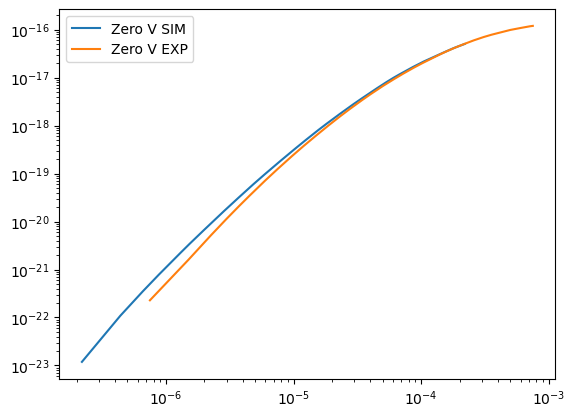

In [15]:
msd_len = 1000
lag_times_sim = 0
lag_times_exp = 0

import random

msds_z_sim = []
for i in range(len(traces_sim)):
    for idx in zero_idxs_sim[i]:
        if idx+msd_len < len(traces_sim[i]):
            super_trace = traces_sim[i][idx:idx + msd_len]
            msd, lag_times_sim = compute_msd(super_trace, 1/fs_sim)
            msds_z_sim.append(msd)

msd_rand_sim = []
for i in range(len(traces_sim)):
    for j in range(len(zero_idxs_sim[i])):
        idx = random.randint(0, len(traces_sim[i]) - msd_len)
        print("v at rand idx is " + str(V_traces_sim[i][idx]))
        reg_trace = traces_sim[i][idx:idx + msd_len]
        msd2, lag_times_sim = compute_msd(reg_trace, 1/fs_sim)
        msd_rand_sim.append(msd2)


msds_z_exp = []
for i in range(len(traces_post_meter_exp)):
    for idx in zero_idxs_exp[i]:
        if idx+msd_len < len(traces_post_meter_exp[i]):
            super_trace = traces_post_meter_exp[i][idx:idx + msd_len]
            msd, lag_times_exp = compute_msd(super_trace, bin_num_exp/sampling_rate)
            msds_z_exp.append(msd)

msd_rand_exp = []
for i in range(len(traces_post_meter_exp)):
    for j in range(len(zero_idxs_exp[i])):
        idx = random.randint(0, len(traces_post_meter_exp[i]) - msd_len)
        print("v at rand idx is " + str(traces_post_meter_exp[i][idx]))
        reg_trace = traces_post_meter_exp[i][idx:idx + msd_len]
        msd2, lag_times_exp = compute_msd(reg_trace, bin_num_exp/sampling_rate)
        msd_rand_exp.append(msd2)

avg_msds_z_sim = np.mean(msds_z_sim, axis=0)
avg_msds_rand_sim = np.mean(msd_rand_sim, axis=0)

avg_msds_z_exp = np.mean(msds_z_exp, axis=0)
avg_msds_rand_exp = np.mean(msd_rand_exp, axis=0)

plt.plot(lag_times_sim[1:], avg_msds_z_sim[1:], label="Zero V SIM")
# plt.plot(lag_times_sim[1:], avg_msds_rand_sim[1:], label="Rand V SIM")

plt.plot(lag_times_exp[1:], avg_msds_z_exp[1:], label="Zero V EXP")
# plt.plot(lag_times_exp[1:], avg_msds_rand_exp[1:], label="Rand V EXP")

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()


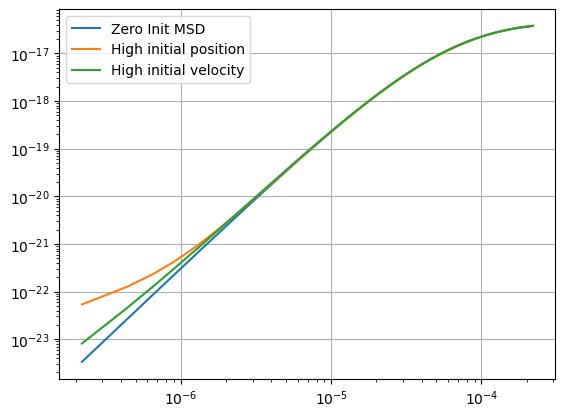

In [105]:
from scipy import constants as const

def analyic_MSD_inital_conditions(t, rho_f, rho_p, a, eta, K, T, x_0_2_a = 0, v_0_2_a = 0, x_0_v_0_a = 0, x_0_a = 0, v_0_a = 0):
    m = (4/3)*math.pi*a**3*rho_p + .5*(4/3)*math.pi*a**3*rho_f
    tau = m/(6*math.pi*a*eta)
    w_0 = math.sqrt(K/m)
    w_1 = math.sqrt((-(w_0**2))+1/(4*tau**2))
    f_p2 = 2*m*const.k*T/tau

    x_2_a = np.exp(-t/tau)*((np.cosh(w_1*t)) ** 2 * x_0_2_a + ((np.sinh(w_1 * t)) ** 2 / w_1 ** 2) * (v_0_2_a + (x_0_2_a / (4 * tau ** 2)) + (2 * x_0_v_0_a) / (2 * tau)) + (f_p2 / (w_1**2 *m ** 2)) * (np.exp(-2 * w_1 * t) * (np.exp(t * (2 * w_1 + 1 / tau)) - 1) / (4 * (2 * w_1 + 1 / tau)) + np.exp(2 * w_1 * t) * (np.exp(t * (-2 * w_1 + 1 / tau)) - 1) / (4 * (-2 * w_1 + 1 / tau)) - (tau / 2) * (np.exp(t / tau) - 1)) + (2 / w_1) * np.cosh(w_1 * t) * np.sinh(w_1 * t) * (x_0_v_0_a + x_0_2_a / (2 * tau)))

    x_a_2 = np.exp(-t/tau)*( (np.cosh(w_1*t)**2 * x_0_a**2)  + (np.sinh(w_1*t)**2/w_1**2)*(v_0_a**2 + x_0_a**2/(4*tau**2) + x_0_a*v_0_a/(2*tau)) + (x_0_a*v_0_a + x_0_a**2/(2*tau))*np.sinh(w_1*t)*np.cosh(w_1*t)/w_1 )

    msd = x_2_a - x_a_2

    return msd

# When x_0 and v_0 are fixed we note that <x_0**2> = <x_0>**2, <v_0**2> = <v_0>**2

x_0_a = 0
v_0_a = 0
x_0_2_a = x_0_a**2
v_0_2_a = 0
x_0_v_0_a = x_0_a*v_0_a

msd = analyic_MSD_inital_conditions(lag_times_sim, 789, 4400,  2.7e-6, .36e-3, 9.384e-5, 293, x_0_2_a, v_0_2_a, x_0_v_0_a, x_0_a, v_0_a)


x_0_a = 1e-10
v_0_a = 0
x_0_2_a = x_0_a**2
v_0_2_a = 0
x_0_v_0_a = x_0_a*v_0_a

msd1 = analyic_MSD_inital_conditions(lag_times_sim, 789, 4400,  2.7e-6, .36e-3, 9.384e-5, 293, x_0_2_a, v_0_2_a, x_0_v_0_a, x_0_a, v_0_a)


x_0_a = 0
v_0_a = 0
x_0_2_a = x_0_a**2
v_0_2_a = 1e-10
x_0_v_0_a = x_0_a*v_0_a

msd2 = analyic_MSD_inital_conditions(lag_times_sim, 789, 4400,  2.7e-6, .36e-3, 9.384e-5, 293, x_0_2_a, v_0_2_a, x_0_v_0_a, x_0_a, v_0_a)

# v_0_a and v_0_2_a msut be different!!
x_0_a = 1e-5
v_0_a = 1e-10
x_0_2_a = x_0_a**2
v_0_2_a = v_0_a**2
x_0_v_0_a = x_0_a*v_0_a

msd3 = analyic_MSD_inital_conditions(lag_times_sim, 789, 4400,  2.7e-6, .36e-3, 9.384e-5, 293, x_0_2_a, v_0_2_a, x_0_v_0_a, x_0_a, v_0_a)


plt.plot(lag_times_sim[1:], msd[1:], label="Zero Init MSD")
plt.plot(lag_times_sim[1:], msd1[1:], label="High initial position")
plt.plot(lag_times_sim[1:], msd2[1:], label="High initial velocity")
# plt.plot(lag_times_sim[1:], msd3[1:], label="High initial mix")

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()


In [ ]:
# THERE IS SOME SUBTLETY TO EXCLUDING THE <F V_0> TERM